### Reference

**Github Repo** : https://github.com/maziarraissi/PINNs

@article{raissi2017physicsI,
  title={Physics Informed Deep Learning (Part I): Data-driven Solutions of Nonlinear Partial Differential Equations},
  author={Raissi, Maziar and Perdikaris, Paris and Karniadakis, George Em},
  journal={arXiv preprint arXiv:1711.10561},
  year={2017}
}

@article{raissi2017physicsII,
  title={Physics Informed Deep Learning (Part II): Data-driven Discovery of Nonlinear Partial Differential Equations},
  author={Raissi, Maziar and Perdikaris, Paris and Karniadakis, George Em},
  journal={arXiv preprint arXiv:1711.10566},
  year={2017}
}

## Libraries and Dependencies

In [1]:
import sys
sys.path.insert(0, '../Utilities/')

import torch
from collections import OrderedDict

!pip install pyDOE
from pyDOE import lhs
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata

# from plotting import newfig, savefig
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import time

np.random.seed(1234)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18184 sha256=7a45c95d158e5ea1e160862645b0a9be28155a8ce8d38bba5d146eb737998fe7
  Stored in directory: /root/.cache/pip/wheels/83/ce/8a/87b25c685bfeca1872d13b8dc101e087a9c6e3fb5ebb47022a
Successfully built pyDOE


In [2]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

## Physics-informed Neural Networks

In [3]:
# the deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self.layers(x)
        return out

In [4]:
# the physics-guided neural network
class PhysicsInformedNN():
    def __init__(self, X_u, u, X_f, layers, lb, ub, nu):
        
        # boundary conditions
        self.lb = torch.tensor(lb).float().to(device)
        self.ub = torch.tensor(ub).float().to(device)
        
        # data
        self.x_u = torch.tensor(X_u[:, 0:1], requires_grad=True).float().to(device)
        self.t_u = torch.tensor(X_u[:, 1:2], requires_grad=True).float().to(device)
        self.x_f = torch.tensor(X_f[:, 0:1], requires_grad=True).float().to(device)
        self.t_f = torch.tensor(X_f[:, 1:2], requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)
        
        self.layers = layers
        self.nu = nu
        
        # deep neural networks
        self.dnn = DNN(layers).to(device)
        
        # optimizers: using the same settings
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        )

        self.iter = 0
        self.ls_tot = []
        self.ls_u = []
        self.ls_f = []
        
    def net_u(self, x, t):  
        u = self.dnn(torch.cat([x, t], dim=1))
        return u
    
    def net_f(self, x, t):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(x, t)
        
        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        f = u_t - self.nu * u_xx
        return f
    # def stor(self):

    
    def loss_func(self):
        self.optimizer.zero_grad()
        
        u_pred = self.net_u(self.x_u, self.t_u)
        f_pred = self.net_f(self.x_f, self.t_f)
        loss_u = torch.mean((self.u - u_pred) ** 2)
        loss_f = torch.mean(f_pred ** 2)
        
        loss = loss_u + loss_f
        
        loss.backward()
        self.iter += 1
        if self.iter % 100 == 0:
            print(
                'Iter %d, Loss: %.5e, Loss_u: %.5e, Loss_f: %.5e' % (self.iter, loss.item(), loss_u.item(), loss_f.item())
            )
        self.ls_tot.append(loss.item())
        self.ls_u.append(loss_u.item())
        self.ls_f.append(loss_f.item())
        return loss
    
    def train(self):
        self.dnn.train()
                
        # Backward and optimize
        self.optimizer.step(self.loss_func)

            
    def predict(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)

        self.dnn.eval()
        u = self.net_u(x, t)
        f = self.net_f(x, t)
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        return u, f

## Configurations

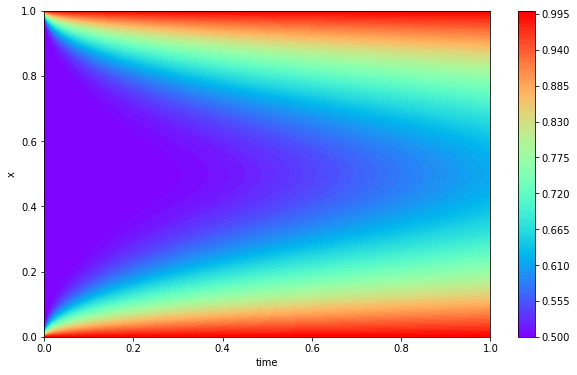

In [5]:
xn = 100
tn = 1000

x = np.linspace(0,1,xn)
t = np.linspace(0,1,tn)

T_,X = np.meshgrid(t,x)

# plt.rcParams['figure.figsize'] = [10,10]

dt = 1/tn
T = 1
mu = 0.05
dx = 1/xn

# Fourier number / Stability < 0.5
lamb = (dt*mu)/dx**2

U = np.zeros((X.shape[0], X.shape[1])) #  SPACE X TIME

# Domain Initialization
U[:,0] = 0.5
#for i in range(100):
    #U[i,0] = 0.4*np.sin(2*np.pi*i)

# Boundary conditions
U[0,:] = 1
U[X.shape[0]-1,:] = 1

RAD = 1
f = 0

# Finite difference method on 1D
for k in range(1,U.shape[1]):
    for i in range(RAD, U.shape[0]-RAD):
        U[i,k] = U[i,k-1] + lamb*(U[i-RAD,k-1] + U[i+RAD,k-1] - 2*U[i,k-1])

plt.figure(1,figsize=(10,6))
levels = plt.MaxNLocator(nbins=100).tick_values(U.min(), U.max())
IM2 = plt.contourf(T_,X,U,levels=levels,cmap=plt.get_cmap('rainbow'))
plt.xticks()
plt.yticks()
plt.xlabel('time')
plt.ylabel('x')
plt.colorbar()

In [9]:
# For FTCS stability, lambda (Fourier number) <= 0.5
lamb

0.5

In [6]:
nu = 0.05 # Mu diffusivity
noise = 0.0        

N_u = 1000 # Number of Boundary Points
N_f = 10000 # 25,000, This is total number of points in your system 

layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1] # Original

t = t.flatten()[:,None]
x = x.flatten()[:,None]

Exact = U.T

X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None]

# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0) 

# Upper boundary
xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T))
uu1 = Exact[0:1,:].T

# Lower boundary
xx4 = np.hstack((X[-1:,:].T, T[-1:,:].T))
uu4 = Exact[-1:,:].T

# Initial condition at t = 0
xx2 = np.hstack((X[:,0:1], T[:,0:1]))
uu2 = Exact[:,0:1]

# final condition
xx3 = np.hstack((X[:,-1:], T[:,-1:]))
uu3 = Exact[:,-1:]

X_u_train = np.vstack([xx1, xx2, xx3])

X_f_train = lb + (ub-lb)*lhs(2, N_f)
X_f_train = np.vstack((X_f_train, X_u_train))
u_train = np.vstack([uu1, uu2, uu3])

idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)
X_u_train = X_u_train[idx, :]
u_train = u_train[idx,:]

## Training

In [7]:
model = PhysicsInformedNN(X_u_train, u_train, X_f_train, layers, lb, ub, nu)

In [8]:
%%time
               
model.train()

Iter 100, Loss: 4.42881e-03, Loss_u: 3.67959e-03, Loss_f: 7.49227e-04
Iter 200, Loss: 2.18689e-03, Loss_u: 2.02995e-03, Loss_f: 1.56934e-04
Iter 300, Loss: 1.95513e-03, Loss_u: 1.93879e-03, Loss_f: 1.63450e-05
Iter 400, Loss: 1.92652e-03, Loss_u: 1.89808e-03, Loss_f: 2.84418e-05
Iter 500, Loss: 1.90443e-03, Loss_u: 1.86655e-03, Loss_f: 3.78722e-05
Iter 600, Loss: 1.87326e-03, Loss_u: 1.82499e-03, Loss_f: 4.82687e-05
Iter 700, Loss: 1.84102e-03, Loss_u: 1.78101e-03, Loss_f: 6.00158e-05
Iter 800, Loss: 1.77482e-03, Loss_u: 1.66797e-03, Loss_f: 1.06847e-04
Iter 900, Loss: 1.50460e-03, Loss_u: 1.42614e-03, Loss_f: 7.84558e-05
Iter 1000, Loss: 1.17593e-03, Loss_u: 1.07748e-03, Loss_f: 9.84516e-05
Iter 1100, Loss: 8.84416e-04, Loss_u: 7.41768e-04, Loss_f: 1.42649e-04
Iter 1200, Loss: 6.70417e-04, Loss_u: 5.55122e-04, Loss_f: 1.15294e-04
Iter 1300, Loss: 5.11110e-04, Loss_u: 4.04963e-04, Loss_f: 1.06148e-04
Iter 1400, Loss: 4.26468e-04, Loss_u: 3.35751e-04, Loss_f: 9.07167e-05
Iter 1500, Loss

In [11]:
u_pred, f_pred = model.predict(X_star)

error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' % (error_u))                     

U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
Error = np.abs(Exact - U_pred)

Error u: 7.135843e-03


## Visualizations

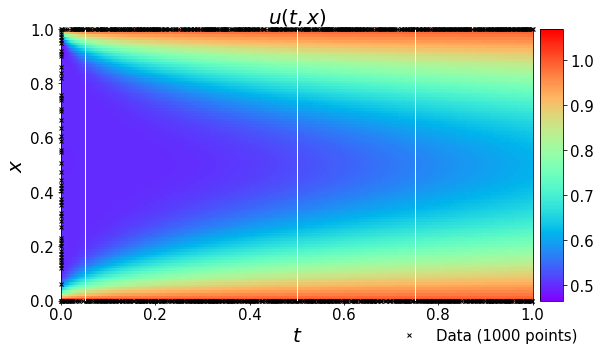

In [12]:
""" The aesthetic setting has changed. """

####### Row 0: u(t,x) ##################    

fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)

h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 

ax.plot(
    X_u_train[:,1], 
    X_u_train[:,0], 
    'kx', label = 'Data (%d points)' % (u_train.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=1.0
)

line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[500]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[750]*np.ones((2,1)), line, 'w-', linewidth = 1)

ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled
ax.tick_params(labelsize=15)

plt.show()

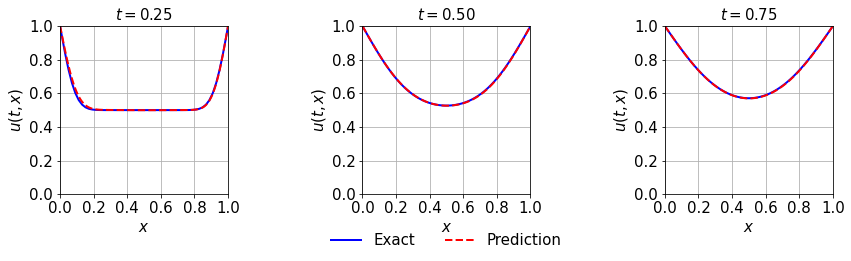

In [13]:
####### Row 1: u(t,x) slices ################## 

""" The aesthetic setting has changed. """

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111)

gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1-1.0/3.0-0.1, bottom=1.0-2.0/3.0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,Exact[50,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('$t = 0.25$', fontsize = 15)
ax.axis('square')
ax.grid()
ax.set_xlim([0.0,1.0])
ax.set_ylim([0.0,1.0])

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 1])
ax.plot(x,Exact[500,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[500,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([0.0,1.0])
ax.set_ylim([0.0,1.0])
ax.set_title('$t = 0.50$', fontsize = 15)
ax.grid()
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.15), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 2])
ax.plot(x,Exact[750,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[750,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([0.0,1.0])
ax.set_ylim([0.0,1.0])    
ax.set_title('$t = 0.75$', fontsize = 15)
ax.grid()

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

plt.show()

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
!wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
from colab_pdf import colab_pdf
colab_pdf('Neuron.ipynb')

--2022-06-09 15:57:25--  https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1864 (1.8K) [text/plain]
Saving to: ‘colab_pdf.py’

colab_pdf.py        100%[===================>]   1.82K  --.-KB/s    in 0s      

2022-06-09 15:57:25 (23.5 MB/s) - ‘colab_pdf.py’ saved [1864/1864]





Extracting templates from packages: 100%
[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/Neuron.ipynb to pdf
[NbConvertApp] Support files will be in Neuron_files/
[NbConvertApp] Making directory ./Neuron_files
[NbConvertApp] Making directory ./Neuron_files
[NbConvertApp] Making directory ./Neuron_files
[NbConvertApp] Writing 71387 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvert

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'File ready to be Downloaded and Saved to Drive'